# Quick Start

This notebook demonstrates how to quickly get started with the `optiwindnet` package to design optimized collector system cable layouts via different routers:
- Heuristics
    - quickest
    - takes sub-second
- Metaheuristics
    - quick
    - gives radial only solutions
    - takes a second or two
- MILP
    - solutions with quality assurance
    - takes a few minutes

In [2]:
from optiwindnet.api import WindFarmNetwork, MetaHeuristic, load_repository

In [3]:
# Display figures as SVG in Jupyter notebooks
%config InlineBackend.figure_formats = ['svg']

### Load location data

>In this example, the `load_repository()` functionality is used to load a prebuilt *Networkx.Graph*. For more details on this functionality look into the notebook about [Load repositories containing location data](api_02-load-repositories.ipynb).

In [4]:
locations = load_repository()
L = locations.doggerA

## Heuristics (quickest in sub-second)

In [5]:
from optiwindnet.heuristics import EW_presolver

In [6]:
%%timeit
P, A = make_planar_embedding(L)

NameError: name 'make_planar_embedding' is not defined

In [ ]:
P, A = make_planar_embedding(L)

In [ ]:
%%timeit
S_pre = EW_presolver(A, capacity=8)

5.38 ms ± 39.9 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
S_pre = EW_presolver(A, capacity=8)

In [ ]:
%%timeit
G_tentative = G_from_S(S_pre, A)
G_pre = PathFinder(G_tentative, planar=P, A=A).create_detours()

32.9 ms ± 829 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
G_tentative = G_from_S(S_pre, A)
G_pre = PathFinder(G_tentative, planar=P, A=A).create_detours()

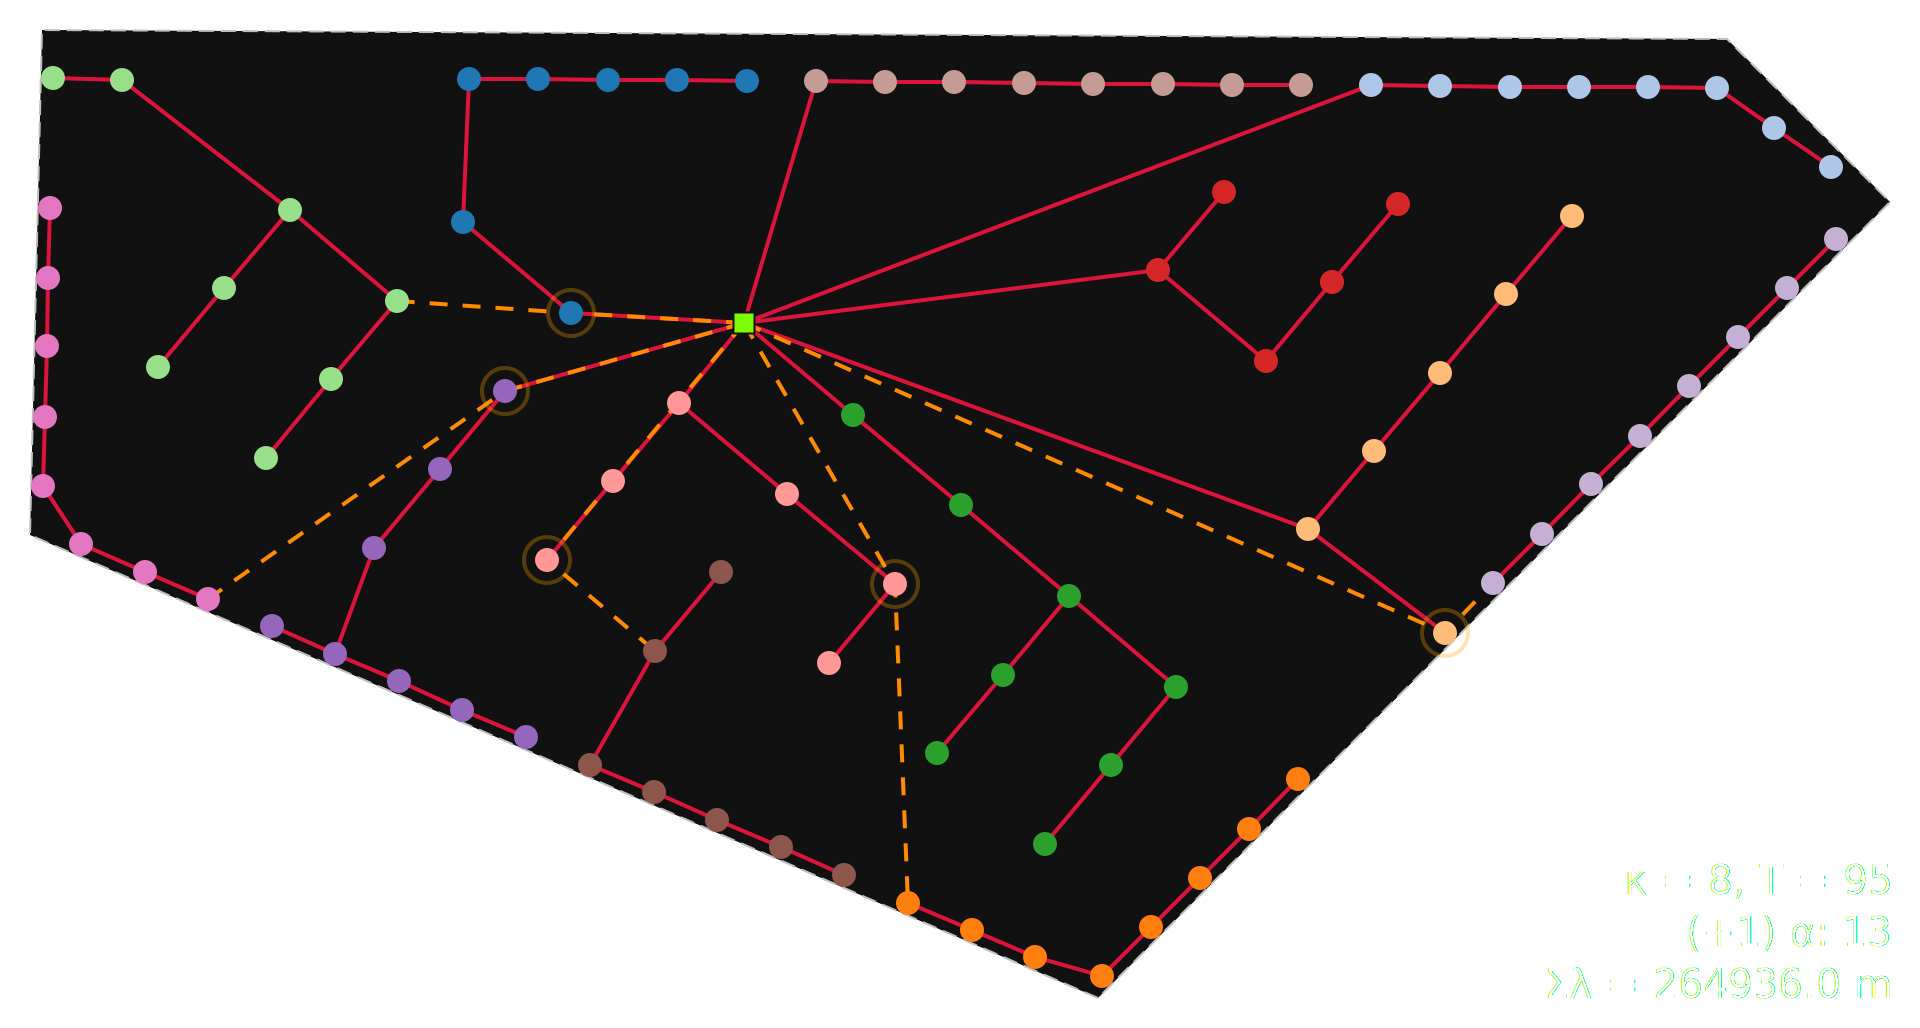

In [ ]:
svgplot(G_pre)

## Metaheuristics (quick, radial only, a second or two)

In [ ]:
from optiwindnet.baselines.hgs import hgs_multiroot
from optiwindnet.interarraylib import as_normalized

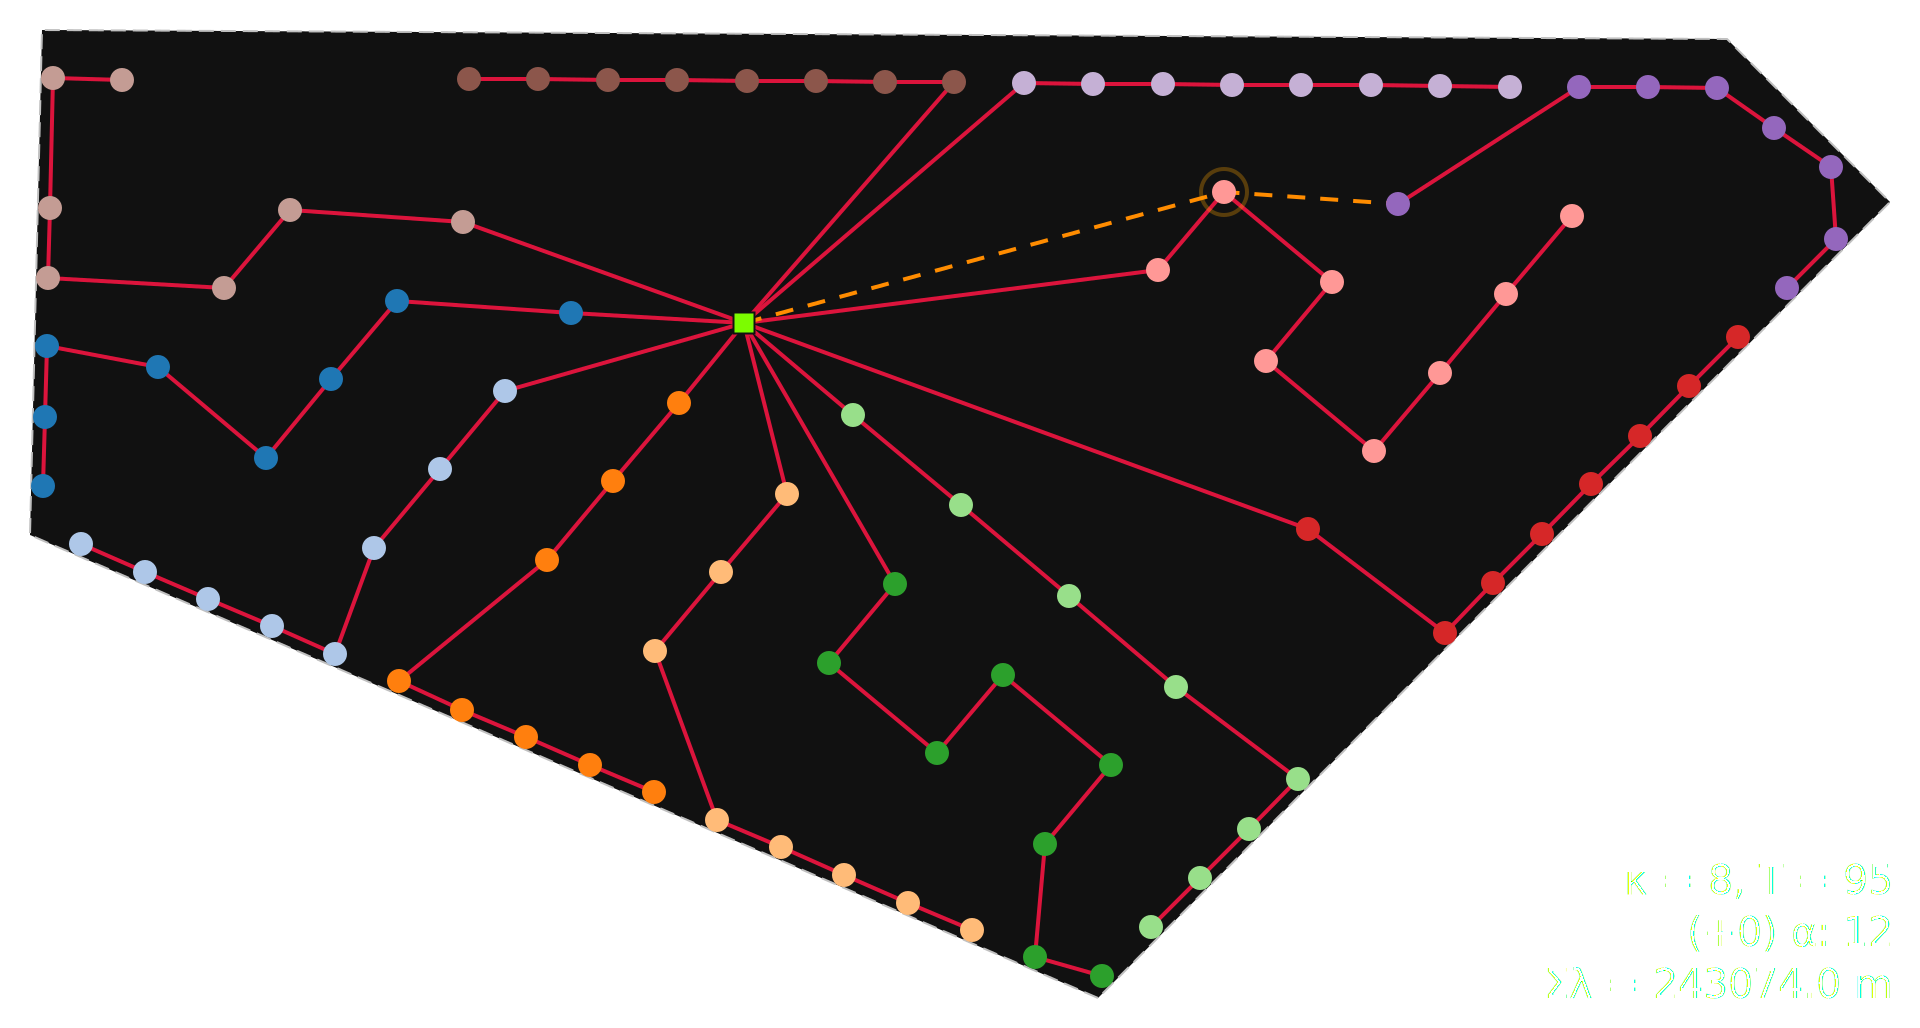

In [ ]:
L = locations.doggerA
P, A = make_planar_embedding(L)
S_hgs = hgs_multiroot(as_normalized(A), capacity=8, time_limit=2)
G_tentative = G_from_S(S_hgs, A)
G_hgs = PathFinder(G_tentative, planar=P, A=A).create_detours()
svgplot(G_hgs)

## MILP (with quality assurance, a few minutes)

In [ ]:
from optiwindnet.MILP import solver_factory, ModelOptions

In [ ]:
solver = solver_factory('ortools')

In [ ]:
ModelOptions.help()

topology in {"radial", "branched", "branched"} default: branched
    Set the topology of subtrees in the solution.

feeder_route in {"straight", "segmented", "segmented"} default: segmented
    If feeder routes must be "straight" or can be detoured ("segmented").

feeder_limit in {"unlimited", "specified", "minimum", "min_plus1", "min_plus2", "min_plus3", "unlimited"} default: unlimited
    Whether to limit the maximum number of feeders, if set to "specified", additional kwarg "max_feeders" must be given.

balanced [bool] default: False
    Whether to enforce balanced subtrees (subtree loads differ at most by one unit).

max_feeders [int] default: 0
    Maximum number of feeders (used only if <feeder_limit = "specified">)



In [ ]:
solver.set_problem(
    P, A, S_hgs.graph['capacity'], ModelOptions(
        topology='branched',
        feeder_route='segmented',
        feeder_limit='unlimited'
    ), warmstart=S_hgs
)

In [ ]:
# required to get the log inside the notebook (goes only to console otherwise)
solver.solver.log_callback = print

solver.solve(
    time_limit=40,
    mip_gap=0.005,
    verbose=True,
)


Starting CP-SAT solver v9.13.4784
Parameters: max_time_in_seconds: 40 log_search_progress: true relative_gap_limit: 0.005
Setting number of workers to 16

Initial optimization model '': (model_fingerprint: 0xd316c113856ac37a)
#Variables: 1'690 (#bools: 845 in floating point objective) (1'500 primary variables)
  - 845 Booleans in [0,1]
  - 750 in [0,7]
  - 95 in [0,8]
#kAtMostOne: 635 (#literals: 1'926)
#kLinear1: 1'690 (#enforced: 1'690)
#kLinear3: 4
#kLinearN: 284 (#terms: 4'213)

Starting presolve at 0.01s
The solution hint is complete and is feasible.
[Scaling] Floating point objective has 845 terms with magnitude in [1409.66, 22631.9] average = 4594.28
[Scaling] Objective coefficient relative error: 1.60816e-10
[Scaling] Objective worst-case absolute error: 5.3597e-05
[Scaling] Objective scaling factor: 2.09715e+06
  6.27e-04s  0.00e+00d  [DetectDominanceRelations] 
  1.23e-02s  0.00e+00d  [operations_research::sat::CpModelPresolver::PresolveToFixPoint] #num_loops=2 #num_dual_str

SolutionInfo(runtime=40.1469286, bound=229538.4338157741, objective=240715.1599014539, relgap=0.04643133440476055, termination='FEASIBLE')

In [ ]:
S, G = solver.get_solution()

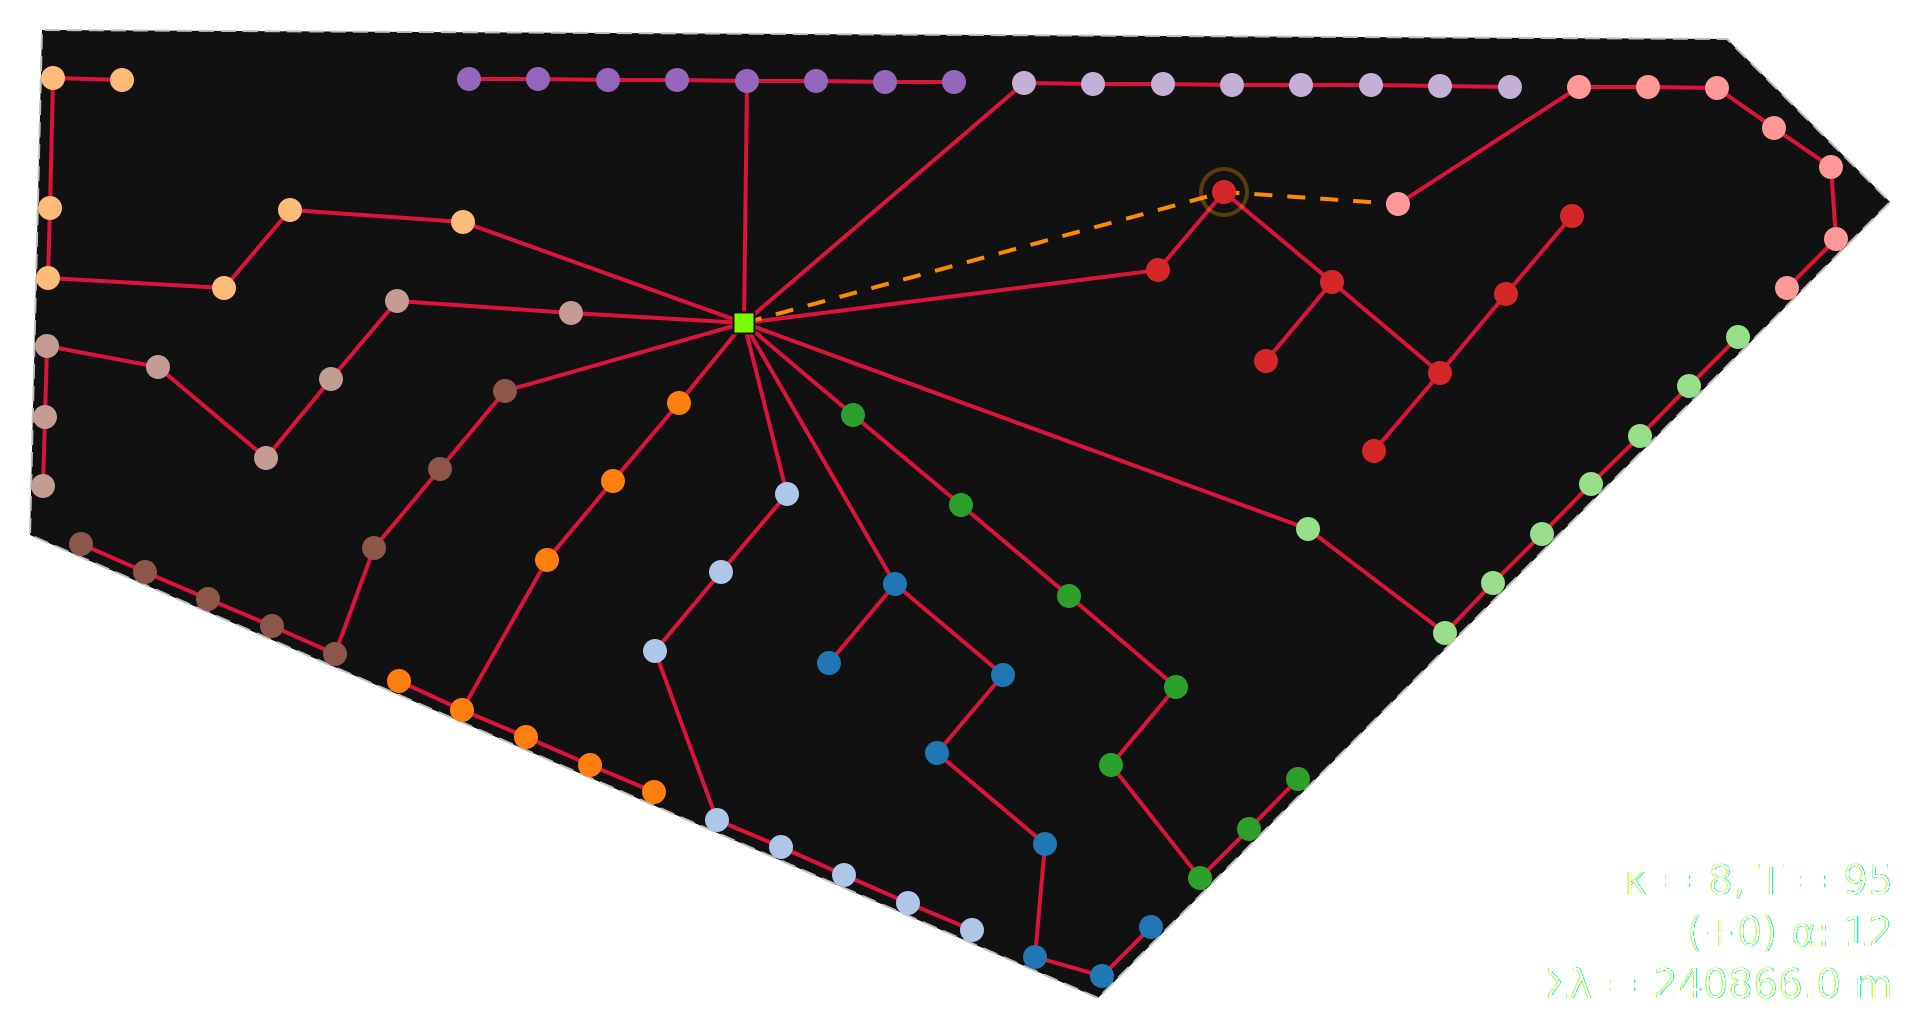

In [ ]:
svgplot(G)

## 🧭 Example Notebooks Overview

This repository includes a set of example notebooks to demonstrate how to use `optiwindnet` for wind farm cable layout optimization. There are **three categories** of notebooks:

### ⚡ Quick Start

A minimal example that shows how to run an optimization in just a few lines using the high-level API. Ideal for first-time users who want to see immediate results with minimal setup. This is presented in this notebook.

---

### 📦 API-Based Examples (Recommended for Most Users)

These notebooks demonstrate how to use the **`optiwindnet` API** via its main class `WindFarmNetwork`. This approach is:

* **Simple** to use
* **Suitable for integration** with tools like **TopFarm**
* Focused on productivity and ease of interaction

Users only need to provide input data and call a few intuitive methods to perform routing and access results.

> ✅ Use these if you want fast prototyping or plan to integrate `optiwindnet` into a larger workflow.

---

### 🛠️ Low-Level Usage Examples

These notebooks show how to use `optiwindnet` by **directly importing its internal modules and functions**. This approach:

* Exposes more customization and internal logic
* Requires calling several intermediate steps (e.g., preprocessing, initial tree generation, optimization, result processing)
* Is useful for **advanced users**, researchers, or developers who want fine control or want to extend the code

> 🔍 Use these if you're exploring the algorithm, debugging, or building on top of the library internals.

